In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
from IPython import display

import wandb
!wandb login 1b8e8dc9dcf1a34397a04197c4826d3fe7441dae

from utils.wandb_helpers import get_runs
from utils.plotting import plot_se

from functools import partial
api = wandb.Api()
get_runs = partial(get_runs, api=api)

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
def group_f(df):
    res = {}
    for col in df:
        if df[col].dtype == 'object':
            res[col] = df[col].iloc[0]
        else:
            res[col] = df[col].mean()
    return pd.Series(res)

### 10-pct overlap

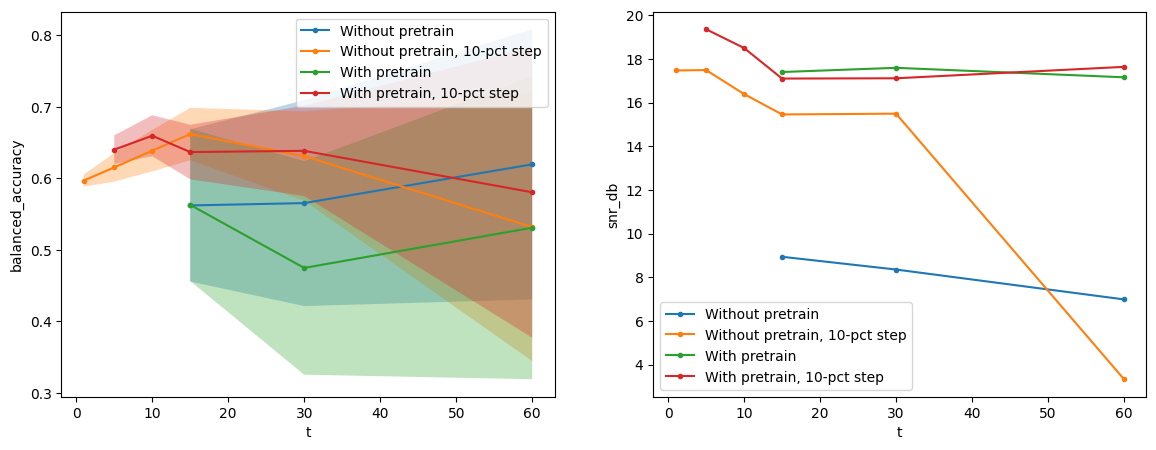

In [4]:
runs_df = get_runs("dmitriykornilov_team/EEG_depression_classification")
results = []
model_type = 'final'

for idx, run in runs_df.iterrows():
    if run['config'].get('hash', 0) in [
        '0x868e5655', #with 10-pct sliding window
        '0x78c6d3bd', #with 10-pct sliding window
        '0x1168f9c', #without 10-pct sliding window
        '0x321f7672', #without 10-pct sliding window
    ] and run['config'].get('run_hash', 0) not in ['9c89bb02d501c7a2']:
        description = run['config']['model']['model_description']
        model = description.split(",")[-1].strip(" ")
        results.append({
            "run_hash": run['config']['run_hash'],
            "t": run['config']['dataset']['samples_shape'][1]/128,
            'time_averaged_embeddings': run["config"]["ml"]["avg_embeddings_over_time"],
            'pretrain': True if 'finetune' in description else False,
            '10-pct step': True if '10-pct step' in description else False,
            'model': model,

            "balanced_accuracy": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy'],
            "balanced_accuracy_se": run['summary'][model_type]['clf.d.test.bs.balanced_accuracy.se'],
            'snr_db': run['summary'][model_type]['snr_db'],
        })
    
results = pd.DataFrame.from_records(results).set_index('run_hash', drop=True)
results = results.groupby("run_hash").apply(group_f).sort_values(['pretrain', 't'])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(2*7, 5))
for idx, df in results.groupby(['pretrain', '10-pct step']): 
    label = f"{'With' if idx[0] else 'Without'} pretrain{', 10-pct step' if idx[1] else ''}"
    plot_se(df['t'], df['balanced_accuracy'], df['balanced_accuracy_se'], label=label, ax=ax[0])
    plot_se(df['t'], df['snr_db'], label=label, ax=ax[1])

ax[0].set_xlabel("t")
ax[0].set_ylabel("balanced_accuracy")
ax[0].legend()
ax[1].set_xlabel("t")
ax[1].set_ylabel("snr_db")
ax[1].legend()
plt.show()